# Homework 2 - Soccer analytics

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc, ConnectionPatch
import seaborn as sns
import sys
import re
import itertools
import collections
import time

from scipy import stats

In [19]:
# datasets used throughout the homework

#matches = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/matches_England.json')
#teams = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/teams.json')
#coaches = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/coaches.json')
#events = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/events_England.json')
#players = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/players.json').set_index('wyId')

# [RQ1] Who wants to be a Champion? 

For this task we first need to select the data concerning the teams in the Premier League from the dataset _"teams.json"_. These correspond exactly to the those teams whose *teamsArea* is either *England* or *Wales*. We get in this way a total of 20 teams.</p>

Successively, we also create a two new dataframes *frame_points* and *PLscores* in order to store the information about the number of points gained by each team during the season both weekly and in total.

In [3]:
# select the 20 teams in the Premier League

teamsAreas = teams.area.apply(pd.Series)  # create a pandas object from the dictionary in teams.area

a = pd.concat([teamsAreas[teamsAreas.name=='England'], teamsAreas[teamsAreas.name=='Wales']])
l = a.index.tolist()  
allEng = teams.loc[l, ['name', 'type', 'wyId']]

PLteams = allEng[allEng.type == 'club'].set_index('name') 
PLteams = PLteams[['wyId']]

In [6]:
# highlight the points gained by each team during the esason

scores = dict.fromkeys(PLteams.wyId, 0) # dictionary with the scores of each team
frame_points = pd.DataFrame.from_dict(dict.fromkeys(PLteams.wyId, [0]*38), orient = 'index', columns = range(1,39))  # weekly points

for i in range(1,39):
    for index, row in matches[matches.gameweek == i].iterrows():
        if row['winner'] !=0:   # row['winner'] is the wyId of the winning team
            scores[row['winner']] += 3
            frame_points.at[row['winner'], i] = 3
        else:
            team1, team2 = re.split(' - |,', row['label'])[:2]
            scores[PLteams.at[team1,'wyId']] +=1
            frame_points.at[PLteams.at[team1,'wyId'], i] = 1
            scores[PLteams.at[team2,'wyId']] +=1
            frame_points.at[PLteams.at[team2,'wyId'], i] = 1
    PLteams[i] = scores.values()

PLscores = PLteams.drop('wyId', axis=1).T  #total points

The following line plot shows the scoring trend of the teams in Premier League during the season 2017/18. Each point *(x,y)* represents the number of points obtained by team x at game week y:

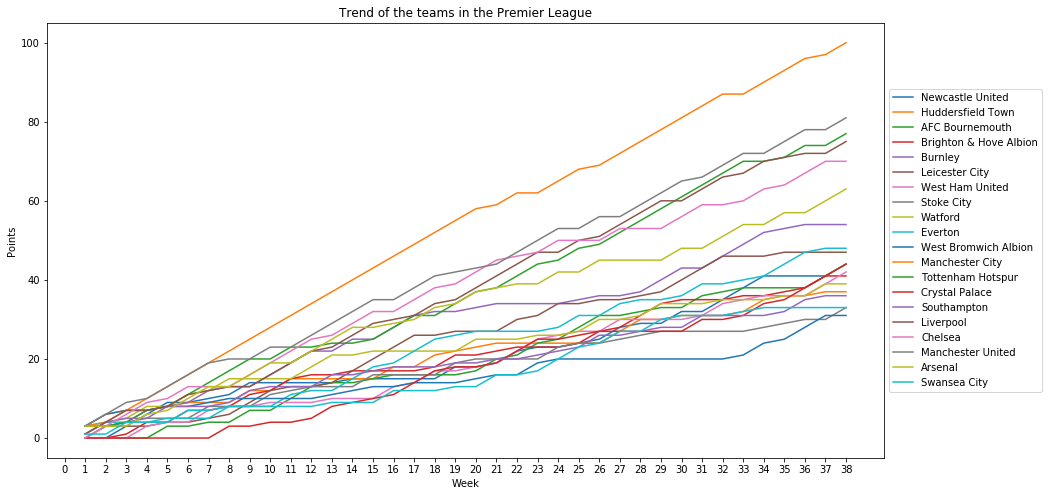

In [7]:
plt.figure(figsize=(15,8))
plt.title('Trend of the teams in the Premier League')
for city in PLscores.columns:
    plt.plot(PLscores[city], label=city)

plt.xlabel('Week')
plt.ylabel('Points')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xticks(range(39))
plt.show()

From the plot above, it is already pretty clear the team of *Manchester City* had a really positive trend during the whole season, whereas teams like *West Browich Albion* and *Crystal Palace* had many consecutive game lost, as we can deduce from long flat sections in their plot.</p>

To confirm our hypothesis, we can analyse deeper our data. In order to highlight the two teams that got the longest winning streak and those who got the longest losing streak, we add three columns to *frame_points* which show the maximum number of occurences of consecutive 0s, 1s, and 3s, for each team. 

In [9]:
zero, one, three = [], [], []

for index, row in frame_points.iterrows():
    points = [row[i] for i in range(1,39)]
    a = ''.join(map(str, points))
    zero.append(max(len(s) for s in re.findall(r'0+', a)))
    one.append(max(len(s) for s in re.findall(r'1+', a)))
    three.append(max(len(s) for s in re.findall(r'3+', a)))
frame_points['max 0'], frame_points['max 1'], frame_points['max 3']= zero, one, three

In [23]:
best, worst = [], []

for index, row in frame_points.nlargest(2,['max 3']).iterrows():
    best += [[index, row['max 3']]]
    
for index, row in frame_points.nlargest(2,['max 0']).iterrows():
    worst += [[index, row['max 0']]]

print('The teams with the two longest winning streak are:\n  ---> ', PLteams[PLteams.wyId==best[0][0]].index.tolist()[0], ', ', best[0][1], ' consecutive games won \n'
'  ---> ', PLteams[PLteams.wyId==best[1][0]].index.tolist()[0], ', ', best[1][1], ' consecutive games won', sep='')

print('\n','The teams with the two longest losing streak are:\n  ---> ', PLteams[PLteams.wyId==worst[0][0]].index.tolist()[0], ', ', worst[0][1], ' consecutive games lost \n'
'  ---> ', PLteams[PLteams.wyId==worst[1][0]].index.tolist()[0], ', ', worst[1][1], ' consecutive games lost', sep='')

The teams with the two longest winning streak are:
  ---> Manchester City, 18 consecutive games won 
  ---> Tottenham Hotspur, 7 consecutive games won

The teams with the two longest losing streak are:
  ---> West Bromwich Albion, 8 consecutive games lost 
  ---> Crystal Palace, 7 consecutive games lost


This actually confirms our previuos observations. In particular, it is really impressive the result obtained by **Manchester City**, with a maximum of 18 consecutive games won.

# [RQ2] Is there a home-field advantage? 

For this task we have selected the following five teams: **Arsenal**, **Burnley**, **Chelsea**, **Everton** and **Watford**. We thought about choosing those teams because they are among those with a similiar number of games won and lost. </n>

Anothoer choice could have been to include in our selection a very strong team and another with a very bad performance, in order to check if the few defeats of the former actually took place in the away-field and, conversely, if the few victories of the latter were performed in the home-field. </p>

In [25]:
# Select data for the five chosen teams

match_A = matches[['Arsenal' in x for x in matches.label]]  
match_B = matches[['Burnley' in x for x in matches.label]]
match_C = matches[['Chelsea' in x for x in matches.label]]
match_E = matches[['Everton' in x for x in matches.label]]
match_W = matches[['Watford' in x for x in matches.label]]

i_A = match_A.index   # Store the indexes of the selected rows
i_B = match_B.index
i_C = match_C.index
i_E = match_E.index
i_W = match_W.index

indexes2 = {'Arsenal' : i_A, 'Burnley': i_B, 'Chelsea' : i_C, 'Everton' : i_E, 'Watford': i_W}
matches2 = {'Arsenal' : match_A, 'Burnley': match_B, 'Chelsea' : match_C, 'Everton' : match_E, 'Watford': match_W}

We want to show if there is a correlation between of outcome of a game (win, draw, lose) and the playing side (home or away). The first step to do this is to create the contingency table of each of the five selected teams.

In [26]:
# Contingency tables of the five selected teams

teams5 = ['Arsenal', 'Burnley', 'Chelsea', 'Everton', 'Watford']
frames = {}

for x in teams5:
    
    home_outcomes = [0]*3
    away_outcomes = [0]*3
    
    for i in indexes2[x]:
        teamHome, teamAway, scoreHome, scoreAway = re.split(' - |, ', matches2[x].at[i,'label'])
        if teamHome == x:
            if scoreHome > scoreAway:
                home_outcomes[0] += 1
            elif scoreHome < scoreAway:
                home_outcomes[2] += 1
            else:
                home_outcomes[1] += 1
        elif teamAway == x:
            if scoreHome > scoreAway:
                away_outcomes[2] += 1
            elif scoreHome < scoreAway:
                away_outcomes[0] += 1
            else:
                away_outcomes[1] += 1
            
    cont_table = pd.DataFrame([home_outcomes, away_outcomes], index = ['Home', 'Away'], columns =['Win', 'Draw', 'Loss'])
    cont_table.loc['Total'] = cont_table.sum()
    cont_table.loc[:,'Total'] = cont_table.sum(axis=1)
    cont_table.columns.name = x
    frames[x] = cont_table

In [30]:
# Visualization of the contingency tables of the five selected teams

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(frames['Arsenal'], frames['Burnley'], frames['Chelsea'], frames['Everton'], frames['Watford'])

Arsenal,Win,Draw,Loss,Total
Home,15,2,2,19
Away,4,4,11,19
Total,19,6,13,38
Burnley,Win,Draw,Loss,Total
Home,7,5,7,19
Away,7,7,5,19
Total,14,12,12,38
Chelsea,Win,Draw,Loss,Total
Home,11,4,4,19
Away,10,3,6,19


The next step is to perform an _'overall'_ ***Chi-squared test***. </p>

We assume as null-hypothesis that there is no correlation between of outcome of a game and the playing side. Also, we take *a = 0.05* as significance level for the *p-value*. If the test return a *p-value* smaller than *a*, then can reject the null-hypothesis ans conclude that there is indeed correlation.</p>

The following test is performed on the contingency table of the team **Arsenal**:

In [38]:
chi = stats.chi2_contingency(np.array([frames['Arsenal'].loc['Home', ['Win','Draw', 'Loss']], frames['Arsenal'].loc['Away', ['Win','Draw', 'Loss']]]))
print('--> Chi-sqared test: ', chi, '\n'
    '--> p-value = ', chi[1])

--> Chi-sqared test:  (13.265856950067477, 0.001316302676697684, 2, array([[9.5, 3. , 6.5],
       [9.5, 3. , 6.5]])) 
--> p-value =  0.001316302676697684


The result of the Chi-squared test tells us that we have to reject the null-hypothesis, since we got a _p-value_ < 0.05. Therfore, at least for the team Arsenel, we can conclude that there is correlation between the outcome of a game and the playing side. 

# [RQ3] Which teams have the youngest coaches?

The first task of this question is to show the teams in Premier Leagues with 10 youngest coches. </p>

To achieve this, we first have to extract form the dataset _"coaches.json"_ the data concerning only the rows we are interested in.

In [48]:
# Create a dictionary whose keys are the identifiers of the teams and whose values are the identifiers of their coaches

d = dict.fromkeys(PLteams.wyId, [])
for i in range(380):
    key1, key2 = map(int, matches.at[i,'teamsData'].keys())
    value1, value2 = map(int, re.findall('(?<=coachId\': )\d+', str(matches.at[i,'teamsData'])))
    d[key1] = d[key1]+[value1]
    d[key2] = d[key2]+[value2]
    
for key in d:  # removing meaningless keys
    d[key] = set(d[key])
    if 0 in d[key]:
        d[key].remove(0)
    # the coach with wyId 3782 found in the match Tottenham-Leicester of the 13/05/2018 doesn't exist in the dataset coaches, 
    # so we assume that this is a mistake in the data and we remove this identifier. From further research on the web, 
    # we realize that the coach of Tottenham for that match was M. Pochettino, whose identifier was already present in our dictonary.   
    if 3782 in d[key]:   
        d[key].remove(3782)
for key in d:
    d[key] = list(d[key])

In [63]:
# Creat a list with the coachId of all the coaches involved in the PL (34 in total)

list_coach = []
for key in d:
    for value in d[key]:
        if value not in list_coach:
            list_coach.append(value)

# Add a column with the age of the coaches in the dataframe PLcoaches

PLcoaches = coaches.set_index('wyId')
PLcoaches = PLcoaches.reindex(list_coach, columns = ['shortName','birthDate', 'currentTeamId']).dropna(subset=['birthDate'])

y, ages = int(time.strftime('%Y')), []
for index, row in PLcoaches.iterrows():
    ages.append(y - int(row['birthDate'][:4]))
PLcoaches['age'] = ages

In [64]:
# For each team in the dictionary, just leave the youngest

for key in d:
    a = []
    for value in d[key]:
        a.append([PLcoaches.at[value,'age']])
        i = a.index(min(a))
    d[key] = d[key][i]
    
# Create a new dataframe containng, for each team in the PL, the identifier and the age of the youngest coach

coach_list, team_list, age = [], [], []

for key in d:
    coach_list.append(d[key])
    team_list.append(key)
    
for x in coach_list:
    age.append(PLcoaches.age[x])
    
new_PLcoaches = pd.DataFrame(list(zip(coach_list,team_list, age, PLteams.index)), columns=['coachId','teamId', 'age', 'name'])
new_PLcoaches = new_PLcoaches.set_index('teamId').sort_values(by = 'age', ascending=False)

Finally, we visualize our result through a bar plot which shows the age of the youngest coach for each team in Premier Leugue. The bars colored in green are the youngest.

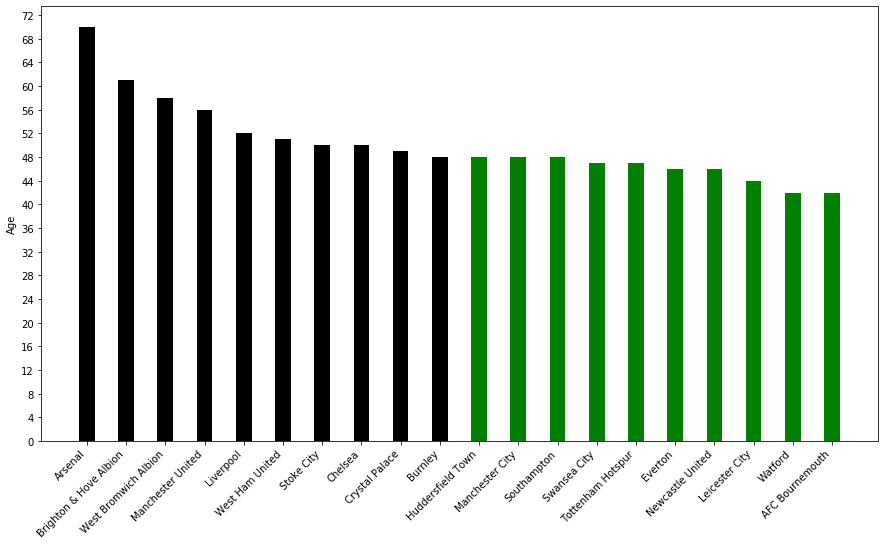

In [65]:
plt.figure(figsize=(15,8))
mycol = 'k'*10 + 'g'*10
plt.bar(new_PLcoaches.name, new_PLcoaches.age, width=0.4, color=mycol)
plt.xticks(rotation=45, ha="right")
plt.ylabel('Age', rotation=90)
plt.yticks(range(0, 74, 4))
plt.show()

The following box plot shows the distribution of the age of all the coaches in Premier League (not only the youngest)

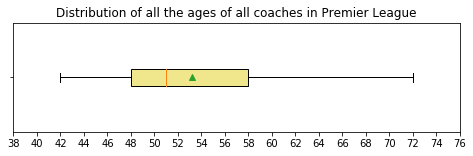

In [68]:
plt.figure(figsize=(8,2))
plt.title('Distribution of all the ages of all coaches in Premier League')
plt.boxplot(PLcoaches.age, vert=0, patch_artist=True, labels=[''], showmeans=True, boxprops=dict(facecolor='khaki', color='black'))
plt.xticks(range(38, 78, 2))
plt.show()

# [RQ4] Which players played better performed passes?

The task here is to find the top 10 players with the highest ratio between completed passes and attempted passes. </p>

Passes are identified in the dataset _"events"_ by the number 8. Moreover, the completed passes can be distinguished from the just attempted ones by the presence of the tag _'id': 1801_ as an attribute of the event. </p>

In order to ignore players who played a really short time, we set **380** as the threashold of minimum attempted passes, which corresponds to an avarege of 10 passes/match.

In [73]:
# Create a dictionary which associates to each player a dataframe containing all his events 

passes = events[events.eventId==8]
d = dict.fromkeys(set(passes.playerId))
for key in d:
    d[key] = passes[passes.playerId == key]

# Create a dictionary with the playerIds as keys and with values: [ratio, shortName]

passes_dict = {}

for key in d:
    if d[key].shape[0]>380:  # exclude players who played a really short time
        s = ''
        for i in d[key].tags:
            s+=str(i)
        passes_dict[key] = [s.count('1801')/d[key].shape[0]]

passes_dict = sorted(passes_dict.items(), key=lambda x: x[1], reverse = True)
for p in passes_dict:
    p[1].append(players.at[p[0], 'shortName']) 

In [72]:
# Display the top 10 players

print('The top 10 players with the highest ratio between completed passes and attempted passes are:')
for p in passes_dict[:10]:
    print(' --> ', p[1][1].encode().decode('utf-8'),', ', round(p[1][0]*100,2), '%', sep='')

The top 10 players with the highest ratio between completed passes and attempted passes are:
 --> J. Stones, 97.59%
 --> Y. Tour\u00e9, 94.8%
 --> F. Delph, 94.51%
 --> V. Kompany, 94.32%
 --> A. Christensen, 94.02%
 --> P. Jones, 93.85%
 --> N. Otamendi, 93.76%
 --> Mohamed Elneny, 93.65%
 --> \u0130. G\u00fcndo\u011fan, 93.56%
 --> V. Lindel\u00f6f, 93.55%


# [RQ5] Does being a tall player mean winning more air duels?

The aim of this task is to find if there is correlation between the height of a player and the number of air duels won. </p>

For each player of the Premier League we find his height and the number of air duels won. In this analysis, we just consider those players who attempted at least 1 air duel per game, for a total of 38 in the whole season.

In [76]:
# create a dictionary which associates to each player a dataframe containing all his events 

duels = events[events.subEventId==10]

d = dict.fromkeys(set(duels.playerId))  # the keys are the playerId of those players involved in air duels
del(d[0])
for key in d:
    d[key] = duels[duels.playerId == key]
    
duels = {}

for key in d:
    if d[key].shape[0]>38:  # exclude players who played a really short time 
        s = ''
        for i in d[key].tags:
            s+=str(i)
        duels[key] = [s.count('1801')/d[key].shape[0]]
        
duels = sorted(duels.items(), key=lambda x: x[1], reverse = True)

for p in duels:
    p[1].append(players.at[p[0], 'shortName']) 
    p[1].append(players.at[p[0], 'height']) 
    
# duels is thus a list of pairs of the type: (playerId, [ratio,'shortName', height])

We represent pur results in the following scatterplot, wher each point *(x,y)* represent a player whose height is equal to *x*, and that has a ratio of winning air duels equal to *y*. 

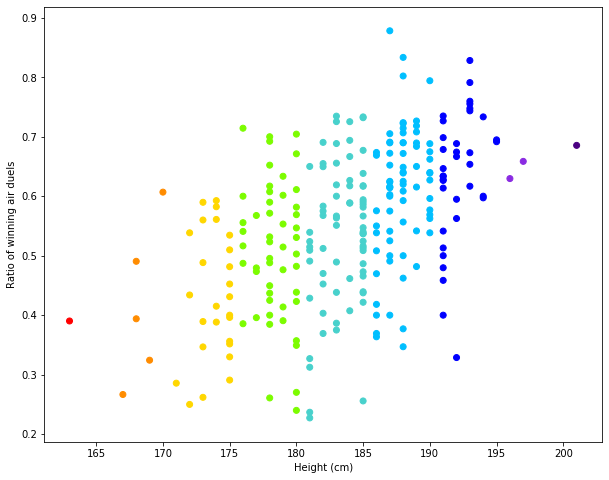

In [75]:
# Scatterplot

h = np.asarray([players.at[p[0], 'height'] for p in duels])  # list of heights
ratio = [p[1][0] for p in duels]  
col = np.where(h < 166, 'r', np.where(h < 171,'darkorange', np.where(h < 176,'gold', np.where(h < 181,'lawngreen', np.where(h < 186,'mediumturquoise', np.where(h < 191,'deepskyblue', np.where(h < 196,'blue', np.where(h < 201,'blueviolet', 'indigo'))))))))

plt.figure(figsize=(10,8))
plt.scatter(h,ratio, c =col)
plt.xlabel('Height (cm)')
plt.ylabel('Ratio of winning air duels')
plt.show()

The scatterplot above presents an uphill pattern, that is, the ratio of air duels won tend to increase when the height of the players also increase.In other words, there is a positive relationship between this two variables.

# [RQ6] Top scores

The aim of this task is to create a barplot displaying the 20 players who scored the highest number of goals during the Premier League season 2017/18.

In [11]:
# From the dataset 'events', just keep the goals

l = []
for i in range(643150):
    x = events.at[i, 'tags']
    for j in range(len(x)):
        if (x[j]['id']== 101 or x[j]['id']== 102) and x[-1]['id'] == 1801:
            l.append(i)
goalsAcc = events.iloc[l,:]

Using the function *Counter*, we can easily get the number of goals scored by each player:

In [13]:
tot = collections.Counter(goalsAcc['playerId'])
names, g = [], []
for e in tot.most_common(20):
    names.append(players.at[e[0], 'shortName']) 
    g.append(e[1])

Finally, we can create the plot:

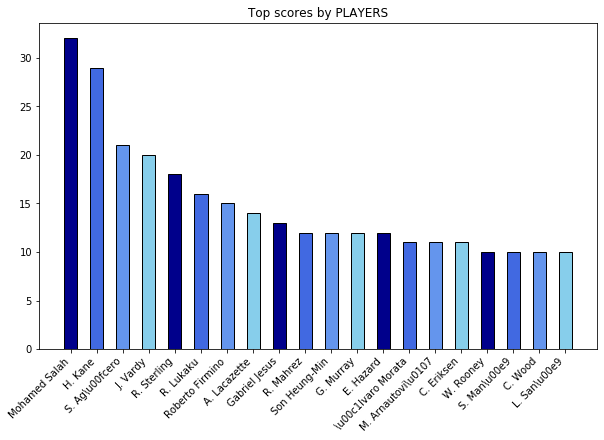

In [18]:
plt.figure(figsize=(10,6))
plt.title('Top scores by PLAYERS')
plt.bar(names,g, width = 0.5, color=['darkblue', 'royalblue', 'cornflowerblue', 'skyblue'], edgecolor = 'k')
plt.xticks(rotation=45, ha="right")
plt.show()

An analogous statistic can be made considering **teams** instead of players:

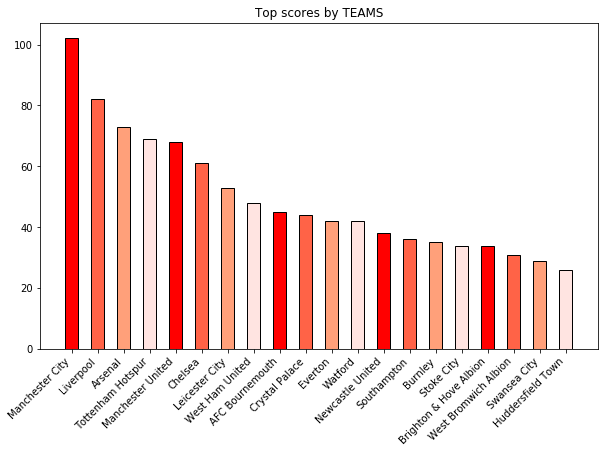

In [17]:
# Counter of the goals per team
totM = collections.Counter(goalsAcc['teamId'])
teams = teams.set_index('wyId')

namesT, gT = [], []
for e in totM.most_common(20):
    namesT.append(teams.at[e[0], 'name']) 
    gT.append(e[1])
    
# Plot
plt.figure(figsize=(10,6))
plt.title('Top scores by TEAMS')
plt.bar(namesT,gT, width = 0.5, color=['r', 'tomato', 'lightsalmon', 'mistyrose'], edgecolor = 'k')
plt.xticks(rotation=45, ha="right")
plt.show()



# [CRQ1] What are the time slots of the match with more goals?

To answer this question, we consider the duration of a match as the union of discrete intervals of nine minutes each, plus two extra intervals that take into account of the arbitrary extra-time at the end of each half of the game.

## 1. Absolute frequency of goals in all the time slots


In [79]:
# From the dataset 'events', just keep the goals

l = []
for i in range(len(events)):
    x = events.at[i, 'tags']
    for j in range(len(x)):
        if (x[j]['id']== 101 or x[j]['id']== 102) and x[-1]['id'] == 1801:
            l.append(i)
goalsAcc = events.iloc[l,:]  

# In this way we get a total of 992 goals out of 1018 ...  

After this research we have been able to extract only 992 goals out of 1018, the total that is reported in the official statitics. Since it already includes both goals and own-goals and since we couldn't figure out other solutions to find the missins data, we just decided to continue the analysis only on the 992 goals found, also because they already represent the 97% of the total and for this reason we believe they can give significant results in any case. 

In [108]:
# first group the goals checking if they have been scored in the first aor second half of the match, 
# then group them again by interval slot

g1, g2 = goalsAcc.groupby('matchPeriod').get_group('1H'), goalsAcc.groupby('matchPeriod').get_group('2H')
bins = pd.interval_range(start=0, periods = 6, freq=540)

# goals in the first time
g1cut = pd.cut(g1["eventSec"],bins)
g1groups = g1cut.groupby(lambda x: g1cut[x])
l1 = list(g1groups.groups.keys())

# goals in the second time
g2cut = pd.cut(g2["eventSec"],bins)
g2groups = g2cut.groupby(lambda x: g2cut[x])
l2 = list(g2groups.groups.keys())

# create a list with the nuber of goals scored in each time slot
abs_freq = []
for i in range(len(g1groups)):
    abs_freq.append(len(g1groups.get_group(l2[i])))
for i in range(len(g2groups)):
    abs_freq.append(len(g2groups.get_group(l2[i])))

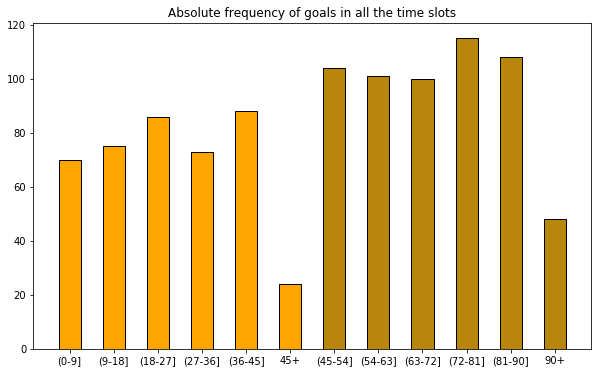

In [109]:
bars = ['(0-9]', '(9-18]', '(18-27]', '(27-36]', '(36-45]', '45+', '(45-54]', '(54-63]', '(63-72]', '(72-81]', '(81-90]', '90+']
plt.figure(figsize=(10,6))
plt.title('Absolute frequency of goals in all the time slots')
col = ['orange']*6 + ['darkgoldenrod']*6
plt.bar(bars, abs_freq, width = 0.5, color = col, edgecolor ='k')
plt.show()

Looking at the bar barplot above, we can observe that there is a tendency of scoring more goals during the second half of the game. In particular, the interval with the highest frequency of goals is the one from the 72nd to the 81st minute of the game.
Another interesting observation is that very few goals are scored during both the extra-times *45+* and *90+*.

## 2.  Top 10 teams of the interval (81-90]

To complete this task, we first select the teams who scored goals in the interval *(81-90]*, then we count how many goals they actually scored in that period. Sorting this values and selecting the teams with the highest number of goals, we obtained the desired top 10 list of teams.

In [90]:
t = []
for i in g2groups.get_group(l2[-2]).index:
    t.append(goalsAcc.at[i,'teamId'])

d = {}
for e in t:
    if e in d.keys():
        d[e] += 1
    else: 
        d[e] = 1        
topTeams = pd.DataFrame.from_dict(d, orient='index').sort_values(0, ascending= False )

print('Top 10 teams that score the most in the interval "81-90"')
for index, row in topTeams.head(10).iterrows():
    print('- ', teams.at[index,'name'], ', ', row[0], ' goals', sep ='')

Top 10 teams that score the most in the interval "81-90"
- Manchester City, 13 goals
- Arsenal, 11 goals
- Chelsea, 10 goals
- Manchester United, 9 goals
- Watford, 7 goals
- Crystal Palace, 7 goals
- Liverpool, 7 goals
- West Ham United, 6 goals
- Tottenham Hotspur, 5 goals
- AFC Bournemouth, 5 goals


Barplot visualization:

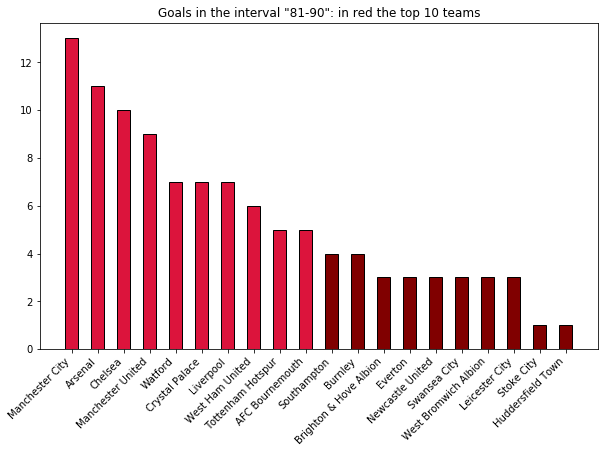

In [116]:
barsT = []
y_coor = []
for index, row in topTeams.iterrows():
    barsT.append(teams.at[index,'name'])
    y_coor.append(row[0])

plt.figure(figsize=(10,6))
plt.title('Goals in the interval "81-90": in red the top 10 teams')
col = ['crimson']*10 +['maroon']*10
plt.bar(barsT, y_coor, width = 0.5, color = col, edgecolor = 'k')
plt.xticks(rotation=45, ha="right")
plt.show()

# 3. Which players scored a goals in at least eight different intervals?

In order to decide if there exist players who scored a goal in at least eight different intervals, we proceed by creating first a list of indeces corresponding to the players who scored at least eight goals during the whole season. Then, for each of this players, we extract the information about his goals from the dataset *goalsAcc* previously created and we determine the number of different intervals to which they belong to by grouping again the goals by time slots.

In [110]:
l = []  # indeces of players who scored at least 8 goals
s = goalsAcc.groupby('playerId').size().sort_values(ascending = False)
for i, k in s.iteritems():
    if k >= 8:
        l.append(i)

# Create a dictonary containing the number of different intervals in which each of the selected player scored at least one goal        
dict_goals = {}
for pl in l:
    dfp = goalsAcc.groupby('playerId').get_group(pl)
    dfp1, dfp2 = dfp.groupby('matchPeriod').get_group('1H'), dfp.groupby('matchPeriod').get_group('2H')
    
    if len(dfp1) >= 2 and len(dfp2) >= 2:   # To get goals in 8 different intervals there should be at least 2 goals in each time of the match
        
        # Get the number of different intervals in 1H in which the player pl scored a goal
        dfp1cut = pd.cut(dfp1["eventSec"],bins)
        dfp1groups = dfp1cut.groupby(lambda x: dfp1cut[x])
        n1 = len(dfp1groups.size())   
        
        # Same for the second time
        dfp2cut = pd.cut(dfp2["eventSec"],bins)
        dfp2groups = dfp2cut.groupby(lambda x: dfp2cut[x])
        n2 = len(dfp2groups.size()) 
        
        dict_goals[pl] = n1+n2

In [122]:
topPlayers = pd.DataFrame.from_dict(dict_goals, orient='index').sort_values(0, ascending= False )
print('Players who score at least one goal in 8 different intervals')
for index, row in topPlayers[topPlayers[0]>=8].iterrows():
    print('- ', players.at[index,'shortName'], ', ', row[0], ' goals', sep ='')

Players who score at least one goal in 8 different intervals
- Mohamed Salah, 11 goals
- J. Vardy, 11 goals
- R. Sterling, 11 goals
- H. Kane, 11 goals
- \u00c1lvaro Morata, 9 goals
- R. Lukaku, 9 goals
- Gabriel Jesus, 9 goals
- R. Mahrez, 9 goals
- Roberto Firmino, 8 goals
- A. Lacazette, 8 goals
- W. Zaha, 8 goals
- M. Arnautovi\u0107, 8 goals


Barplot visualization:

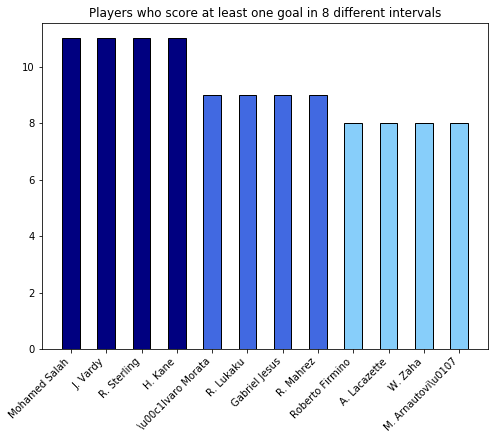

In [121]:
barsP = []
y_coor = []
for index, row in TP.iterrows():
    barsP.append(players.at[index,'shortName'])
    y_coor.append(row[0])
    
plt.figure(figsize=(8,6))
plt.title('Players who score at least one goal in 8 different intervals')
col = ['navy']*4+['royalblue']*4+['lightskyblue']*4
plt.bar(barsP, y_coor, width = 0.5, color = col, edgecolor = 'k')
plt.xticks(rotation=45, ha="right")
plt.show()

# [CRQ2] Visualize movements and passes on the pitch! 

## 1. Visualization of heatmaps

The first point of this question is about the match **Barcelona - Real Madrid** played on the 6th of May 2018. Being it part of a different competition, namely **La Liga**, we have to import the new corresponding datasets.</p>

Since the task only concerns the two players **Cristiano Ronaldo** and **Lionel Messi**, we also select from the datasets just their data.

In [18]:
#eventsS = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/events_Spain.json')
#matchesS = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/matches_Spain.json')

matchId = matchesS.at[23,'wyId']   # mathchId of the game Barcelona - Real Madrid of the 6.05.2018

ronaldo = players[players.shortName == 'Cristiano Ronaldo']  
messi = players[players.shortName == 'L. Messi']

# Dataframes of passes, shots, free kicks and duels made by Ronaldo and Messi

evR = eventsS[(eventsS.matchId==matchId) & (eventsS.playerId == ronaldo.index[0]) & (eventsS.eventId.isin([1,3,8,10]))] 
evM = eventsS[(eventsS.matchId==matchId) & (eventsS.playerId == messi.index[0]) & (eventsS.eventId.isin([1,3,8,10]))] 

We want to creat a heatmap showing the zones in which the two players Cristiano Ronaldo and Lionel Messi were more active. The events that we are taking into account are: **passes**, **shoots**, **duels**, **free kicks**.</p>

The fist step to do that is to define a function that draws the lines of the pitch, as follows:

In [3]:
def draw_pitch(ax):
    
    # Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
   
    # Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    # Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)

    # Circles
    centreCircle = plt.Circle((60,40), 8.1, color="black", fill = False)
    centreSpot = plt.Circle((60,40), 0.71, color="black")

    # Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40), 0.71, color="black")
    rightPenSpot = plt.Circle((110.3,40), 0.71, color="black")
    leftArc = Arc((9.7,40), height=16.2, width=16.2, angle=0, theta1=310, theta2=50, color="black")
    rightArc = Arc((110.3,40), height=16.2, width=16.2, angle=0, theta1=130, theta2=230, color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

With the following code we add "color" to the pitch according to the zones in which the two players have been more active. This analysis takes into account the starting positions of all the events in wihch the players were involved.

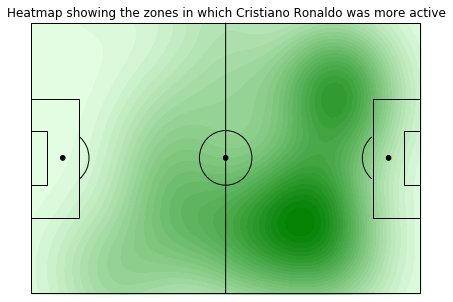

In [27]:
# Ronaldo's heatmap

fig = plt.figure() 
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)

draw_pitch(ax)     

plt.ylim(-0.6, 80)
plt.xlim(0, 120.6)
plt.axis('off')
plt.title('Heatmap showing the zones in which Cristiano Ronaldo was more active')

x_coord, y_coord = [], []
for i in range(len(evR)):
    x_coord.append(evR.iloc[i]['positions'][0]['x'])
    y_coord.append(evR.iloc[i]['positions'][0]['y'])

a = sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)  # Heatmap!!

plt.show()

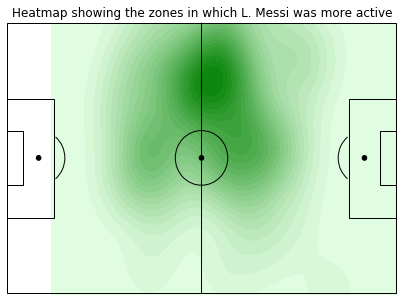

In [28]:
# Messi's heatmap

fig = plt.figure() 
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)

draw_pitch(ax)     

plt.ylim(-0.6, 80)
plt.xlim(0, 120.6)
plt.axis('off')
plt.title('Heatmap showing the zones in which L. Messi was more active')

x_coord, y_coord = [], []
for i in range(len(evM)):
    x_coord.append(evM.iloc[i]['positions'][0]['x'])
    y_coord.append(evM.iloc[i]['positions'][0]['y'])

b = sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)  # Heatmap!!

plt.show()

The figures shown above present many differences. First, it looks like Cristiano Ronaldo has been pretty active in a wider portion of the pitch compared to Messi. In addition, he stayed mainly in bottom-right part of the pitch, whereas Messi was in the top-center part of the pitch for most of the time. 

## 2. Heatmaps with arrows

In this second task we deal with the match **Juventus - Napoli** played on the 22nd of April 2018. In particular, we want to show the starting and ending points of all the passes made by two players **Jorginho** and **Pjanić**. To accomplish this, we add arrows on the heatmap of both of them.</p>

First, we also have to import the new datasets concerning the Italian national competition:

In [37]:
#eventsI = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/events_Italy.json')
#matchesI = pd.read_json(r'C:/Users/Clara/Desktop/sapienza/ADM/HM2/matches_Italy.json')

matchId = matchesI.at[41,'wyId']   # mathchId of the game Juventus - Napoli of the 22.04.2018

jorginho = players[players.firstName == 'Jorge Luiz']  
pjanic = players[players.firstName == 'Miralem']

# Dataframes of passes made by Jorginho and Pjanić

evJ = eventsI[(eventsI.matchId==matchId) & (eventsI.playerId == int(jorginho.index[0])) & (eventsI.eventId==8)] 
evP = eventsI[(eventsI.matchId==matchId) & (eventsI.playerId == int(pjanic.index[0])) & (eventsI.eventId==8)] 

Now we can draw the two figures. We use the same function *draw_pitch(ax)* and we also distinguish the **accurate passes** from the **not accurate** ones giving different colors to the corresponding arrows.

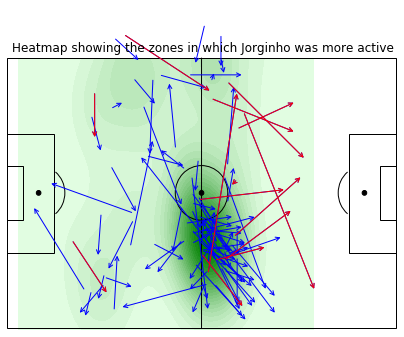

In [38]:
# Visualize the pitch as a heatmap with arrows (Jorginho)

fig = plt.figure() 
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)

draw_pitch(ax)     

plt.ylim(-0.6, 80)
plt.xlim(0, 120.6)
plt.axis('off')
plt.title('Heatmap showing the zones in which Jorginho was more active')

x_coord, y_coord = [], []
for i in range(len(evJ)):
    x_coord.append(evJ.iloc[i]['positions'][0]['x'])
    y_coord.append(evJ.iloc[i]['positions'][0]['y'])

# Select not accurates events ('id': 1082)    
notAcc = []
for i in range(len(evJ)):
    if evJ.iloc[i]['tags'][-1]['id']!=1801:
        notAcc.append(i)
NevJ = evJ.iloc[notAcc]  

sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)  # Heatmap!!

# Add the arrows, giving different colors to accurate and not accurate passes
for i in range(len(evJ)):
    ax.annotate("", xy = (evJ.iloc[i]['positions'][1]['x'], evJ.iloc[i]['positions'][1]['y']), xycoords = 'data',
               xytext = (evJ.iloc[i]['positions'][0]['x'], evJ.iloc[i]['positions'][0]['y']), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)
    
for i in range(len(NevJ)):
    ax.annotate("", xy = (NevJ.iloc[i]['positions'][1]['x'], NevJ.iloc[i]['positions'][1]['y']), xycoords = 'data',
               xytext = (NevJ.iloc[i]['positions'][0]['x'], NevJ.iloc[i]['positions'][0]['y']), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)

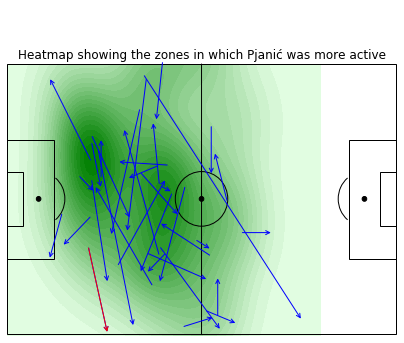

In [39]:
# Visualize the pitch as a heatmap with arrows (Pjanić)

fig = plt.figure() 
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)

draw_pitch(ax)     

plt.ylim(-0.6, 80)
plt.xlim(0, 120.6)
plt.axis('off')
plt.title('Heatmap showing the zones in which Pjanić was more active')

x_coord, y_coord = [], []

for i in range(len(evP)):
    x_coord.append(evP.iloc[i]['positions'][0]['x'])
    y_coord.append(evP.iloc[i]['positions'][0]['y'])

# Select not accurates events ('id': 1082)   
notAcc = []
for i in range(len(evP)):
    if evP.iloc[i]['tags'][-1]['id']!=1801:
        notAcc.append(i)
NevP = evP.iloc[notAcc]  # Dataframe with only not accurate passes

sns.kdeplot(x_coord, y_coord, shade = "True", color = "green", n_levels = 30)  # Heatmap!!

for i in range(len(evP)):
    ax.annotate("", xy = (evP.iloc[i]['positions'][1]['x'], evP.iloc[i]['positions'][1]['y']), xycoords = 'data',
               xytext = (evP.iloc[i]['positions'][0]['x'], evP.iloc[i]['positions'][0]['y']), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"),)

# Not accurate passes will be coloured with red
for i in range(len(NevP)):
    ax.annotate("", xy = (NevP.iloc[i]['positions'][1]['x'], NevP.iloc[i]['positions'][1]['y']), xycoords = 'data',
               xytext = (NevP.iloc[i]['positions'][0]['x'], NevP.iloc[i]['positions'][0]['y']), textcoords = 'data',
               arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "red"),)
    
plt.show()

More than in the previous case, the heatmaps obtained result to be very different. Jorginho was mainly in a small part of the pitch, very close to its center. On the contrary, Pjanić has been moving pretty widely in the left part of the pitch. Also, it is interesting to see that, among all his passes, Pjanić completed all of them except from one. Jorginho attempted many more passes, but a lot of them weren't actually accurate.